# Data Scrapping

Referensi : 
1. https://github.com/KhuswatunHasanahh/sentimen-shopee/blob/main/Analisis_Sentimen_Ulasan_Aplikasi_Shopee_di_google_play_store_Menggunakan_Metode_Klasifikasi_Algoritma_Naive_Bayes.ipynb
2. https://youtu.be/ztV7_--D2GM?si=aM46eZsnwIMOkbTA

In [ ]:
pip install google-play-scraper

In [1]:
# Import library
from google_play_scraper import app
from google_play_scraper import Sort, reviews
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import sent_tokenize, word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB

In [2]:
# Melakukan Scrape jumlah ulasan

result, continuation_token = reviews(
    'com.bukalapak.android',
    lang = 'id',
    country = 'id', # Bahasa Indonesia
    sort = Sort.MOST_RELEVANT, # Sorting ulasan yang paling Relevan
    count = 1200, # Jumlah ulasan/sample 
    filter_score_with=None # Mengambil semua rating bintang 1 s/d 5
)

In [3]:
df = pd.DataFrame(np.array(result), columns=['review'])
df = df.join(pd.DataFrame(df.pop('review').tolist()))
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,a06d5cad-3976-4398-83a1-8848d0941eba,Suryana Yana97,https://play-lh.googleusercontent.com/a/ACg8oc...,Tagihan sudah di bayar dan limit sudah kembali...,1,153,5.42.1,2024-06-16 20:08:39,None,NaT,5.42.1
1,2fbbb70c-d7b8-4cb2-a043-86ae45147be6,Samrozi Ozi,https://play-lh.googleusercontent.com/a-/ALV-U...,"Sangat kecewa dgn paylatter nya, kadang bisa k...",2,29,5.42.1,2024-06-14 14:44:41,None,NaT,5.42.1
2,ed7676c4-8a21-47e8-835a-ef27b52d7965,syarif2207,https://play-lh.googleusercontent.com/a-/ALV-U...,Susahnya mau jadi pelapak di sini. Verifikasi ...,3,0,5.42.1,2024-06-26 10:08:00,None,NaT,5.42.1
3,e0018160-e99a-4eaf-8b76-b05af4af4fbf,Myzna Hits,https://play-lh.googleusercontent.com/a-/ALV-U...,Kecewa sama Bukalapak.. bertahun2 pake paylate...,1,4,5.42.1,2024-06-25 21:49:49,None,NaT,5.42.1
4,188c0586-f5d4-40c4-a06b-75c43d73758a,ade irwan,https://play-lh.googleusercontent.com/a/ACg8oc...,Di bukalapak sistem returan barangnya kacau sa...,1,5,5.42.1,2024-06-23 13:26:29,None,NaT,5.42.1


In [4]:
# Hitung lagi data
len(df.index)

1200

In [5]:
# Filter kolom dari dataframe (Username, Score, Content dan at)
df[['userName', 'score', 'content', 'at']].head(10) # tampilkan 10 data

,userName,score,content,at
0,Suryana Yana97,1,Tagihan sudah di bayar dan limit sudah kembali...,2024-06-16 20:08:39
1,Samrozi Ozi,2,"Sangat kecewa dgn paylatter nya, kadang bisa k...",2024-06-14 14:44:41
2,syarif2207,3,Susahnya mau jadi pelapak di sini. Verifikasi ...,2024-06-26 10:08:00
3,Myzna Hits,1,Kecewa sama Bukalapak.. bertahun2 pake paylate...,2024-06-25 21:49:49
4,ade irwan,1,Di bukalapak sistem returan barangnya kacau sa...,2024-06-23 13:26:29
5,Dri Rindou,2,Mengajukan penggantian no karena no lama hilan...,2024-06-27 22:09:58
6,E MUAMAR S,1,Kenapa ribet sekali ingin mengganti alamat sur...,2024-05-20 00:52:22
7,Nevin Romeo,1,Aplikasi Bukalapak dari dulu sampai sekarang k...,2024-06-03 06:52:38
8,Dodik Yudiawan,4,Pelayanan komplain buruk. Saat komplain tidak ...,2024-06-16 19:36:05
9,Rahmat Tulloh,5,Sering belanja pulsa listrik dan bayar air tap...,2024-06-24 12:34:45


In [6]:
# Sort berdasarkan at atau review terbaru 
df_baru = df[['userName', 'score', 'content', 'at']]
df_at = df_baru.sort_values(by='at', ascending=False)
df_at.head(10)

,userName,score,content,at
30,Iwan Setiawan,3,"Mohon maaf bintang nya kami kurangi dulu,,,,kn...",2024-06-28 20:13:49
12,muhammad nurhadi,1,Tagihan sudah di bayar dan limit sudah kembali...,2024-06-28 19:56:50
24,pina Pina,1,Saldo banyak karena sebelumnya pakai aplikasi ...,2024-06-28 19:04:32
297,andri setiawan,5,trima kasih sangat membantu untuk belanja barang,2024-06-28 18:19:48
917,al_faqir cikarang,2,Jgn pernah menghubungkan akun Bukalapak dgn ak...,2024-06-28 12:05:57
101,Andre Hapsoro,3,"saran.....mestinya jika paylater by KREDIFO,ta...",2024-06-28 11:33:10
384,Anak Pandawa,1,Kenapa saya tidak melakukan transaksi pembelia...,2024-06-28 09:10:23
120,Agus Setiawan,1,Knpa saldo sya tidak segera di kembalikan pada...,2024-06-28 05:04:44
136,Aris Rose,1,saya beli hp di sini hilang saat pengiriman tp...,2024-06-27 23:08:13
5,Dri Rindou,2,Mengajukan penggantian no karena no lama hilan...,2024-06-27 22:09:58


In [7]:
# menyimpan df_at ke data
data = df_at[['userName', 'score', 'content', 'at']]

In [8]:
# filter menjadi kolom content dan score 
data = data[['content', 'score']] # hanya memakai kolom content dan score
data.head(10)

,content,score
30,"Mohon maaf bintang nya kami kurangi dulu,,,,kn...",3
12,Tagihan sudah di bayar dan limit sudah kembali...,1
24,Saldo banyak karena sebelumnya pakai aplikasi ...,1
297,trima kasih sangat membantu untuk belanja barang,5
917,Jgn pernah menghubungkan akun Bukalapak dgn ak...,2
101,"saran.....mestinya jika paylater by KREDIFO,ta...",3
384,Kenapa saya tidak melakukan transaksi pembelia...,1
120,Knpa saldo sya tidak segera di kembalikan pada...,1
136,saya beli hp di sini hilang saat pengiriman tp...,1
5,Mengajukan penggantian no karena no lama hilan...,2


# Data Labeling

In [9]:
def label(score):
    if score < 3:
        return 'Negatif'
    elif score == 4:
        return 'Positif'
    elif score == 5:
        return 'Positif'
        
data['Sentimen'] = data['score'].apply(label)
pd.set_option('display.max_colwidth', None) # Menampilkan seluruh isi kolom
data.head(20)

,content,score,Sentimen
30,"Mohon maaf bintang nya kami kurangi dulu,,,,knpa limit paylater nya jdi gk bisa di pake,,,,padhal pembayaran selalu tepat waktu,,,tolong di perbaiki lgi",3,None
12,"Tagihan sudah di bayar dan limit sudah kembali. Tapi pas mau di pakai lagi paylater Bukalapak malah gak bisa sudah hampir 1bulan, konyol. Sudah di hapus di instal lagi dihapus di instal lagi hampir 10kali masih tetep pembayaran paylater Bukalapak tetep ga bisa. Diketerangan sedang terjadi gangguan sistem, sistem hancur kacau, kembali duit ku woi ajig sumpah mending jgn di download ini apak rugi"" aku menyarankan kalian yg mau download untuk jgn di download malah dia"" nanti duit kalian.",1,Negatif
24,"Saldo banyak karena sebelumnya pakai aplikasi yang versi lama, tapi sekarang saldonya jadi panjangan doang, ga bisa dipakai untuk bayar bayar",1,Negatif
297,trima kasih sangat membantu untuk belanja barang,5,Positif
917,Jgn pernah menghubungkan akun Bukalapak dgn akun dana karena tempatnya sarang penipuan sisanya lemah tentang penipuan sangat mudah. Sudah banyak teman kena tipu di aplikasi ini dan dana.. termasuk sy pribadi kena pas komplein penipuan malah akun Bukalapak sy di non aktifkan..,2,Negatif
101,"saran.....mestinya jika paylater by KREDIFO,tagihan bisa di lihat di pihak ke3...jadi ribet buka aplikasi ini itu....ringkas dan sederhana.",3,None
384,Kenapa saya tidak melakukan transaksi pembelian apapun kenapa saldo didana saya terpotong,1,Negatif
120,Knpa saldo sya tidak segera di kembalikan padahal saya tidak pernah merasa membeli sesuatu di bukalapak ini tolong di kembalikan saldo dana saya yang di sedot sama bukalapak,1,Negatif
136,saya beli hp di sini hilang saat pengiriman tp uang tidak kembali saat th 2018 . komplain juga tidak d tanggapi,1,Negatif
5,Mengajukan penggantian no karena no lama hilang eh gagal terus pas ferifikasi poto KTP sama selfi. Padahal udah jelas banget foto nya tetap saja notif nya foto tidak terbaca sistem. Mengajukan formulir penggantian tetap saja hk bisa ngirim formulir nya. Perbaikin dong sistem nya. Dan syarat pengajuan nya di bikin ringkas lagi.,2,Negatif


In [10]:
# simpan ke file csv
data.to_csv('scrapped_data.csv', index = False)

# Data Cleaning

In [11]:
data = pd.read_csv('scrapped_data.csv')
data.head()

,content,score,Sentimen
0,"Mohon maaf bintang nya kami kurangi dulu,,,,knpa limit paylater nya jdi gk bisa di pake,,,,padhal pembayaran selalu tepat waktu,,,tolong di perbaiki lgi",3,NaN
1,"Tagihan sudah di bayar dan limit sudah kembali. Tapi pas mau di pakai lagi paylater Bukalapak malah gak bisa sudah hampir 1bulan, konyol. Sudah di hapus di instal lagi dihapus di instal lagi hampir 10kali masih tetep pembayaran paylater Bukalapak tetep ga bisa. Diketerangan sedang terjadi gangguan sistem, sistem hancur kacau, kembali duit ku woi ajig sumpah mending jgn di download ini apak rugi"" aku menyarankan kalian yg mau download untuk jgn di download malah dia"" nanti duit kalian.",1,Negatif
2,"Saldo banyak karena sebelumnya pakai aplikasi yang versi lama, tapi sekarang saldonya jadi panjangan doang, ga bisa dipakai untuk bayar bayar",1,Negatif
3,trima kasih sangat membantu untuk belanja barang,5,Positif
4,Jgn pernah menghubungkan akun Bukalapak dgn akun dana karena tempatnya sarang penipuan sisanya lemah tentang penipuan sangat mudah. Sudah banyak teman kena tipu di aplikasi ini dan dana.. termasuk sy pribadi kena pas komplein penipuan malah akun Bukalapak sy di non aktifkan..,2,Negatif


In [12]:
# Cek dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   content   1200 non-null   object
 1   score     1200 non-null   int64 
 2   Sentimen  1099 non-null   object
dtypes: int64(1), object(2)
memory usage: 28.3+ KB


In [13]:
data.isna().any()

content     False
score       False
Sentimen     True
dtype: bool

In [14]:
# Statistik Deskriptif
data.describe(include='all')

,content,score,Sentimen
count,1200,1200.000000,1099
unique,1200,NaN,2
top,"Mohon maaf bintang nya kami kurangi dulu,,,,knpa limit paylater nya jdi gk bisa di pake,,,,padhal pembayaran selalu tepat waktu,,,tolong di perbaiki lgi",NaN,Negatif
freq,1,NaN,667
mean,NaN,2.653333,NaN
std,NaN,1.743757,NaN
min,NaN,1.000000,NaN
25%,NaN,1.000000,NaN
50%,NaN,2.000000,NaN
75%,NaN,5.000000,NaN


In [15]:
# Menampilkan jumlah baris null
data.isnull().sum()

content       0
score         0
Sentimen    101
dtype: int64

In [16]:
# Menghapus baris null
data.dropna(subset=['Sentimen'],inplace=True)

In [17]:
data.isnull().sum()

content     0
score       0
Sentimen    0
dtype: int64

In [18]:
# simpan hasil ke file csv
data.to_csv('bukalapaksentimen.csv', index=False)

# Text preProcessing

In [19]:
df_2 = pd.read_csv('bukalapaksentimen.csv')
df_2.head(10)

,content,score,Sentimen
0,"Tagihan sudah di bayar dan limit sudah kembali. Tapi pas mau di pakai lagi paylater Bukalapak malah gak bisa sudah hampir 1bulan, konyol. Sudah di hapus di instal lagi dihapus di instal lagi hampir 10kali masih tetep pembayaran paylater Bukalapak tetep ga bisa. Diketerangan sedang terjadi gangguan sistem, sistem hancur kacau, kembali duit ku woi ajig sumpah mending jgn di download ini apak rugi"" aku menyarankan kalian yg mau download untuk jgn di download malah dia"" nanti duit kalian.",1,Negatif
1,"Saldo banyak karena sebelumnya pakai aplikasi yang versi lama, tapi sekarang saldonya jadi panjangan doang, ga bisa dipakai untuk bayar bayar",1,Negatif
2,trima kasih sangat membantu untuk belanja barang,5,Positif
3,Jgn pernah menghubungkan akun Bukalapak dgn akun dana karena tempatnya sarang penipuan sisanya lemah tentang penipuan sangat mudah. Sudah banyak teman kena tipu di aplikasi ini dan dana.. termasuk sy pribadi kena pas komplein penipuan malah akun Bukalapak sy di non aktifkan..,2,Negatif
4,Kenapa saya tidak melakukan transaksi pembelian apapun kenapa saldo didana saya terpotong,1,Negatif
5,Knpa saldo sya tidak segera di kembalikan padahal saya tidak pernah merasa membeli sesuatu di bukalapak ini tolong di kembalikan saldo dana saya yang di sedot sama bukalapak,1,Negatif
6,saya beli hp di sini hilang saat pengiriman tp uang tidak kembali saat th 2018 . komplain juga tidak d tanggapi,1,Negatif
7,Mengajukan penggantian no karena no lama hilang eh gagal terus pas ferifikasi poto KTP sama selfi. Padahal udah jelas banget foto nya tetap saja notif nya foto tidak terbaca sistem. Mengajukan formulir penggantian tetap saja hk bisa ngirim formulir nya. Perbaikin dong sistem nya. Dan syarat pengajuan nya di bikin ringkas lagi.,2,Negatif
8,Pertama x belanja online dr aplikasi ini padahal menu nya makin lama makin berkurang. Skr paylater di bayar terus SM limit full LG mlhan GK bsa di pakai .. ya udh dech kita uninstall aja. Goodbye bukalapak,1,Negatif
9,Sepi banget sekarang jualan dibukalapak. 1tahun lebih blm laku 1 barang pun...,5,Positif


In [20]:
# Case Folding/Mengubah semua huruf dalam teks menjadi huruf kecil atau besar
# ubah ke Lowercase

def clean_text(df_2, text_field, new_text_field_name):
    data[new_text_field_name] = data[text_field].str.lower()
    data[new_text_field_name] = data[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\s+)|^rt|http.+?", "", elem))
    
    # Hapus Number
    data[new_text_field_name] = data[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    return data

In [21]:
data['lowerCase'] = data['content'].str.lower()
data['lowerCase']
data_clean = clean_text(data, 'content', 'lowerCase')
data_clean.head(10)

,content,score,Sentimen,lowerCase
1,"Tagihan sudah di bayar dan limit sudah kembali. Tapi pas mau di pakai lagi paylater Bukalapak malah gak bisa sudah hampir 1bulan, konyol. Sudah di hapus di instal lagi dihapus di instal lagi hampir 10kali masih tetep pembayaran paylater Bukalapak tetep ga bisa. Diketerangan sedang terjadi gangguan sistem, sistem hancur kacau, kembali duit ku woi ajig sumpah mending jgn di download ini apak rugi"" aku menyarankan kalian yg mau download untuk jgn di download malah dia"" nanti duit kalian.",1,Negatif,tagihan sudah di bayar dan limit sudah kembali tapi pas mau di pakai lagi paylater bukalapak malah gak bisa sudah hampir bulan konyol sudah di hapus di instal lagi dihapus di instal lagi hampir kali masih tetep pembayaran paylater bukalapak tetep ga bisa diketerangan sedang terjadi gangguan sistem sistem hancur kacau kembali duit ku woi ajig sumpah mending jgn di download ini apak rugi aku menyarankan kalian yg mau download untuk jgn di download malah dia nanti duit kalian
2,"Saldo banyak karena sebelumnya pakai aplikasi yang versi lama, tapi sekarang saldonya jadi panjangan doang, ga bisa dipakai untuk bayar bayar",1,Negatif,saldo banyak karena sebelumnya pakai aplikasi yang versi lama tapi sekarang saldonya jadi panjangan doang ga bisa dipakai untuk bayar bayar
3,trima kasih sangat membantu untuk belanja barang,5,Positif,trima kasih sangat membantu untuk belanja barang
4,Jgn pernah menghubungkan akun Bukalapak dgn akun dana karena tempatnya sarang penipuan sisanya lemah tentang penipuan sangat mudah. Sudah banyak teman kena tipu di aplikasi ini dan dana.. termasuk sy pribadi kena pas komplein penipuan malah akun Bukalapak sy di non aktifkan..,2,Negatif,jgn pernah menghubungkan akun bukalapak dgn akun dana karena tempatnya sarang penipuan sisanya lemah tentang penipuan sangat mudah sudah banyak teman kena tipu di aplikasi ini dan dana termasuk sy pribadi kena pas komplein penipuan malah akun bukalapak sy di non aktifkan
6,Kenapa saya tidak melakukan transaksi pembelian apapun kenapa saldo didana saya terpotong,1,Negatif,kenapa saya tidak melakukan transaksi pembelian apapun kenapa saldo didana saya terpotong
7,Knpa saldo sya tidak segera di kembalikan padahal saya tidak pernah merasa membeli sesuatu di bukalapak ini tolong di kembalikan saldo dana saya yang di sedot sama bukalapak,1,Negatif,knpa saldo sya tidak segera di kembalikan padahal saya tidak pernah merasa membeli sesuatu di bukalapak ini tolong di kembalikan saldo dana saya yang di sedot sama bukalapak
8,saya beli hp di sini hilang saat pengiriman tp uang tidak kembali saat th 2018 . komplain juga tidak d tanggapi,1,Negatif,saya beli hp di sini hilang saat pengiriman tp uang tidak kembali saat th komplain juga tidak d tanggapi
9,Mengajukan penggantian no karena no lama hilang eh gagal terus pas ferifikasi poto KTP sama selfi. Padahal udah jelas banget foto nya tetap saja notif nya foto tidak terbaca sistem. Mengajukan formulir penggantian tetap saja hk bisa ngirim formulir nya. Perbaikin dong sistem nya. Dan syarat pengajuan nya di bikin ringkas lagi.,2,Negatif,mengajukan penggantian no karena no lama hilang eh gagal terus pas ferifikasi poto ktp sama selfi padahal udah jelas banget foto nya tetap saja notif nya foto tidak terbaca sistem mengajukan formulir penggantian tetap saja hk bisa ngirim formulir nya perbaikin dong sistem nya dan syarat pengajuan nya di bikin ringkas lagi
11,Pertama x belanja online dr aplikasi ini padahal menu nya makin lama makin berkurang. Skr paylater di bayar terus SM limit full LG mlhan GK bsa di pakai .. ya udh dech kita uninstall aja. Goodbye bukalapak,1,Negatif,pertama x belanja online dr aplikasi ini padahal menu nya makin lama makin berkurang skr paylater di bayar terus sm limit full lg mlhan gk bsa di pakai ya udh dech kita uninstall aja goodbye bukalapak
12,Sepi banget sekarang jualan dibukalapak. 1tahun lebih blm laku 1 barang pun...,5,Positif,sepi banget sekarang jualan dibukalapak tahun lebih blm l

In [26]:
pip install nltk

     ---------------------------------------- 0.0/42.0 kB ? eta -:--:--
     ---------------------------------------  41.0/42.0 kB ? eta -:--:--
     ---------------------------------------- 42.0/42.0 kB 2.0 MB/s eta 0:00:00
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------- ----------- 41.0/57.6 kB 1.9 MB/s eta 0:00:01
     ---------------------------------------- 57.6/57.6 kB 1.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.5 MB 1.9 MB/s eta 0:00:01
   -- ------------------------------------- 0.1/1.5 MB 907.3 kB/s eta 0:00:02
   --- ------------------------------------ 0.1/1.5 MB 1.0 MB/s eta 0:00:02
   ------ --------------------------------- 0.2/1.5 MB 1.5 MB/s eta 0:00:01
   ------- -------------------------------- 0.3/1.5 MB 1.4 MB/s eta 0:00:01
   -------- ------------------------------- 0.3/1.5 MB 1.4 MB/s eta 0:00:01
   -------- ----

In [22]:
# menghapus stopwords 
# (kata-kata umum yang tidak memberikan informasi signifikan seperti "dan", "atau", dll.)

nltk.download('stopwords')
stop = stopwords.words('indonesian')
tambahan_stopwords = ['aja', 'aj', 'yang', 'dll', 'sih', 'dari', 'dr', 'saya', 'dan', 'di', 'bisa',
                      'juga', 'saja', 'sj', 'pake', 'ini', 'tidak', 'tdk', 'untuk', 'utk', 'yg',
                      'x', 'lg', 'skr', 'gk', 'ya', 'tp', 'ya', 'ga', 'w', 'udh', 'tau' 'blm', 'blom',
                      'gak', 'nya', 'ksh', 'sm', 'bsa', 'bisa', 'atu', 'jg', 'skg', 'bs', 'dan']

stop.extend(tambahan_stopwords)

import string
def bersihkan_teks(teks):
    teks = teks.translate(str.maketrans('', '', string.punctuation))
    teks = ''.join([i for i in teks if not i.isdigit()])
    teks = ' '.join([word for word in teks.split() if word not in (stop)])
    return teks

data_clean['text_StopWord'] = data_clean['lowerCase'].apply(bersihkan_teks)
data_clean.head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\miku3\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,content,score,Sentimen,lowerCase,text_StopWord
1,"Tagihan sudah di bayar dan limit sudah kembali. Tapi pas mau di pakai lagi paylater Bukalapak malah gak bisa sudah hampir 1bulan, konyol. Sudah di hapus di instal lagi dihapus di instal lagi hampir 10kali masih tetep pembayaran paylater Bukalapak tetep ga bisa. Diketerangan sedang terjadi gangguan sistem, sistem hancur kacau, kembali duit ku woi ajig sumpah mending jgn di download ini apak rugi"" aku menyarankan kalian yg mau download untuk jgn di download malah dia"" nanti duit kalian.",1,Negatif,tagihan sudah di bayar dan limit sudah kembali tapi pas mau di pakai lagi paylater bukalapak malah gak bisa sudah hampir bulan konyol sudah di hapus di instal lagi dihapus di instal lagi hampir kali masih tetep pembayaran paylater bukalapak tetep ga bisa diketerangan sedang terjadi gangguan sistem sistem hancur kacau kembali duit ku woi ajig sumpah mending jgn di download ini apak rugi aku menyarankan kalian yg mau download untuk jgn di download malah dia nanti duit kalian,tagihan bayar limit pas pakai paylater bukalapak konyol hapus instal dihapus instal kali tetep pembayaran paylater bukalapak tetep diketerangan gangguan sistem sistem hancur kacau duit ku woi ajig sumpah mending jgn download apak rugi menyarankan download jgn download duit
2,"Saldo banyak karena sebelumnya pakai aplikasi yang versi lama, tapi sekarang saldonya jadi panjangan doang, ga bisa dipakai untuk bayar bayar",1,Negatif,saldo banyak karena sebelumnya pakai aplikasi yang versi lama tapi sekarang saldonya jadi panjangan doang ga bisa dipakai untuk bayar bayar,saldo pakai aplikasi versi saldonya panjangan doang dipakai bayar bayar
3,trima kasih sangat membantu untuk belanja barang,5,Positif,trima kasih sangat membantu untuk belanja barang,trima kasih membantu belanja barang
4,Jgn pernah menghubungkan akun Bukalapak dgn akun dana karena tempatnya sarang penipuan sisanya lemah tentang penipuan sangat mudah. Sudah banyak teman kena tipu di aplikasi ini dan dana.. termasuk sy pribadi kena pas komplein penipuan malah akun Bukalapak sy di non aktifkan..,2,Negatif,jgn pernah menghubungkan akun bukalapak dgn akun dana karena tempatnya sarang penipuan sisanya lemah tentang penipuan sangat mudah sudah banyak teman kena tipu di aplikasi ini dan dana termasuk sy pribadi kena pas komplein penipuan malah akun bukalapak sy di non aktifkan,jgn menghubungkan akun bukalapak dgn akun dana tempatnya sarang penipuan sisanya lemah penipuan mudah teman kena tipu aplikasi dana sy pribadi kena pas komplein penipuan akun bukalapak sy non aktifkan
6,Kenapa saya tidak melakukan transaksi pembelian apapun kenapa saldo didana saya terpotong,1,Negatif,kenapa saya tidak melakukan transaksi pembelian apapun kenapa saldo didana saya terpotong,transaksi pembelian apapun saldo didana terpotong
7,Knpa saldo sya tidak segera di kembalikan padahal saya tidak pernah merasa membeli sesuatu di bukalapak ini tolong di kembalikan saldo dana saya yang di sedot sama bukalapak,1,Negatif,knpa saldo sya tidak segera di kembalikan padahal saya tidak pernah merasa membeli sesuatu di bukalapak ini tolong di kembalikan saldo dana saya yang di sedot sama bukalapak,knpa saldo sya kembalikan membeli bukalapak tolong kembalikan saldo dana sedot bukalapak
8,saya beli hp di sini hilang saat pengiriman tp uang tidak kembali saat th 2018 . komplain juga tidak d tanggapi,1,Negatif,saya beli hp di sini hilang saat pengiriman tp uang tidak kembali saat th komplain juga tidak d tanggapi,beli hp hilang pengiriman uang th komplain d tanggapi
9,Mengajukan penggantian no karena no lama hilang eh gagal terus pas ferifikasi poto KTP sama selfi. Padahal udah jelas banget foto nya tetap saja notif nya foto tidak terbaca sistem. Mengajukan formulir penggantian tetap saja hk bisa ngirim formulir nya. Perbaikin dong sistem nya. Dan syarat pengajuan nya di bikin ringkas lagi.,2,Negatif,mengajukan penggantian no karena no lama hilang eh gagal terus pas ferifikasi poto ktp sama selfi padah

In [23]:
# Tokenisasi
'''proses membagi teks mentah menjadi unit-unit yang lebih kecil, yang disebut token.'''

nltk.download('punkt')
data_clean['text_tokens'] = data_clean['text_StopWord'].apply(lambda x: word_tokenize(x))
data_clean.head(10)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\miku3\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,content,score,Sentimen,lowerCase,text_StopWord,text_tokens
1,"Tagihan sudah di bayar dan limit sudah kembali. Tapi pas mau di pakai lagi paylater Bukalapak malah gak bisa sudah hampir 1bulan, konyol. Sudah di hapus di instal lagi dihapus di instal lagi hampir 10kali masih tetep pembayaran paylater Bukalapak tetep ga bisa. Diketerangan sedang terjadi gangguan sistem, sistem hancur kacau, kembali duit ku woi ajig sumpah mending jgn di download ini apak rugi"" aku menyarankan kalian yg mau download untuk jgn di download malah dia"" nanti duit kalian.",1,Negatif,tagihan sudah di bayar dan limit sudah kembali tapi pas mau di pakai lagi paylater bukalapak malah gak bisa sudah hampir bulan konyol sudah di hapus di instal lagi dihapus di instal lagi hampir kali masih tetep pembayaran paylater bukalapak tetep ga bisa diketerangan sedang terjadi gangguan sistem sistem hancur kacau kembali duit ku woi ajig sumpah mending jgn di download ini apak rugi aku menyarankan kalian yg mau download untuk jgn di download malah dia nanti duit kalian,tagihan bayar limit pas pakai paylater bukalapak konyol hapus instal dihapus instal kali tetep pembayaran paylater bukalapak tetep diketerangan gangguan sistem sistem hancur kacau duit ku woi ajig sumpah mending jgn download apak rugi menyarankan download jgn download duit,"[tagihan, bayar, limit, pas, pakai, paylater, bukalapak, konyol, hapus, instal, dihapus, instal, kali, tetep, pembayaran, paylater, bukalapak, tetep, diketerangan, gangguan, sistem, sistem, hancur, kacau, duit, ku, woi, ajig, sumpah, mending, jgn, download, apak, rugi, menyarankan, download, jgn, download, duit]"
2,"Saldo banyak karena sebelumnya pakai aplikasi yang versi lama, tapi sekarang saldonya jadi panjangan doang, ga bisa dipakai untuk bayar bayar",1,Negatif,saldo banyak karena sebelumnya pakai aplikasi yang versi lama tapi sekarang saldonya jadi panjangan doang ga bisa dipakai untuk bayar bayar,saldo pakai aplikasi versi saldonya panjangan doang dipakai bayar bayar,"[saldo, pakai, aplikasi, versi, saldonya, panjangan, doang, dipakai, bayar, bayar]"
3,trima kasih sangat membantu untuk belanja barang,5,Positif,trima kasih sangat membantu untuk belanja barang,trima kasih membantu belanja barang,"[trima, kasih, membantu, belanja, barang]"
4,Jgn pernah menghubungkan akun Bukalapak dgn akun dana karena tempatnya sarang penipuan sisanya lemah tentang penipuan sangat mudah. Sudah banyak teman kena tipu di aplikasi ini dan dana.. termasuk sy pribadi kena pas komplein penipuan malah akun Bukalapak sy di non aktifkan..,2,Negatif,jgn pernah menghubungkan akun bukalapak dgn akun dana karena tempatnya sarang penipuan sisanya lemah tentang penipuan sangat mudah sudah banyak teman kena tipu di aplikasi ini dan dana termasuk sy pribadi kena pas komplein penipuan malah akun bukalapak sy di non aktifkan,jgn menghubungkan akun bukalapak dgn akun dana tempatnya sarang penipuan sisanya lemah penipuan mudah teman kena tipu aplikasi dana sy pribadi kena pas komplein penipuan akun bukalapak sy non aktifkan,"[jgn, menghubungkan, akun, bukalapak, dgn, akun, dana, tempatnya, sarang, penipuan, sisanya, lemah, penipuan, mudah, teman, kena, tipu, aplikasi, dana, sy, pribadi, kena, pas, komplein, penipuan, akun, bukalapak, sy, non, aktifkan]"
6,Kenapa saya tidak melakukan transaksi pembelian apapun kenapa saldo didana saya terpotong,1,Negatif,kenapa saya tidak melakukan transaksi pembelian apapun kenapa saldo didana saya terpotong,transaksi pembelian apapun saldo didana terpotong,"[transaksi, pembelian, apapun, saldo, didana, terpotong]"
7,Knpa saldo sya tidak segera di kembalikan padahal saya tidak pernah merasa membeli sesuatu di bukalapak ini tolong di kembalikan saldo dana saya yang di sedot sama bukalapak,1,Negatif,knpa saldo sya tidak segera di kembalikan padahal saya tidak pernah merasa membeli sesuatu di bukalapak ini tolong di kembalikan saldo dana saya yang di sedot sama bukalapak,knpa saldo sya kembalikan membeli bukalapak tolong kembalikan sald

In [33]:
pip install Sastrawi


   ---------------------------------------- 0.0/209.7 kB ? eta -:--:--
   ----- --------------------------------- 30.7/209.7 kB 660.6 kB/s eta 0:00:01
   --------------------- ------------------ 112.6/209.7 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 209.7/209.7 kB 1.6 MB/s eta 0:00:00


Stemming

In [24]:
# Stemming
# Menguraikan bentuk kata ke bentuk dasarnya dengan library Sastrawi

factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [25]:
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}
hitung = 0

for document in data_clean['text_tokens']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '

print(len(term_dict))
print(25*'-')
for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    hitung+=1
    print(hitung, ":", term, ":", term_dict[term])

print(term_dict)
print(25*'-')

def get_stemmed_term(document):
    return [term_dict[term] for term in document]



4726
-------------------------
1 : tagihan : tagih
2 : bayar : bayar
3 : limit : limit
4 : pas : pas
5 : pakai : pakai
6 : paylater : paylater
7 : bukalapak : bukalapak
8 : konyol : konyol
9 : hapus : hapus
10 : instal : instal
11 : dihapus : hapus
12 : kali : kali
13 : tetep : tetep
14 : pembayaran : bayar
15 : diketerangan : terang
16 : gangguan : ganggu
17 : sistem : sistem
18 : hancur : hancur
19 : kacau : kacau
20 : duit : duit
21 : ku : ku
22 : woi : woi
23 : ajig : ajig
24 : sumpah : sumpah
25 : mending : mending
26 : jgn : jgn
27 : download : download
28 : apak : apak
29 : rugi : rugi
30 : menyarankan : saran
31 : saldo : saldo
32 : aplikasi : aplikasi
33 : versi : versi
34 : saldonya : saldo
35 : panjangan : panjang
36 : doang : doang
37 : dipakai : pakai
38 : trima : trima
39 : kasih : kasih
40 : membantu : bantu
41 : belanja : belanja
42 : barang : barang
43 : menghubungkan : hubung
44 : akun : akun
45 : dgn : dgn
46 : dana : dana
47 : tempatnya : tempat
48 : sarang : sarang

In [26]:
data_clean['text_stemindo'] = data_clean['text_tokens'].apply(lambda x:' '.join(get_stemmed_term(x)))
data_clean.head(20)

,content,score,Sentimen,lowerCase,text_StopWord,text_tokens,text_stemindo
1,"Tagihan sudah di bayar dan limit sudah kembali. Tapi pas mau di pakai lagi paylater Bukalapak malah gak bisa sudah hampir 1bulan, konyol. Sudah di hapus di instal lagi dihapus di instal lagi hampir 10kali masih tetep pembayaran paylater Bukalapak tetep ga bisa. Diketerangan sedang terjadi gangguan sistem, sistem hancur kacau, kembali duit ku woi ajig sumpah mending jgn di download ini apak rugi"" aku menyarankan kalian yg mau download untuk jgn di download malah dia"" nanti duit kalian.",1,Negatif,tagihan sudah di bayar dan limit sudah kembali tapi pas mau di pakai lagi paylater bukalapak malah gak bisa sudah hampir bulan konyol sudah di hapus di instal lagi dihapus di instal lagi hampir kali masih tetep pembayaran paylater bukalapak tetep ga bisa diketerangan sedang terjadi gangguan sistem sistem hancur kacau kembali duit ku woi ajig sumpah mending jgn di download ini apak rugi aku menyarankan kalian yg mau download untuk jgn di download malah dia nanti duit kalian,tagihan bayar limit pas pakai paylater bukalapak konyol hapus instal dihapus instal kali tetep pembayaran paylater bukalapak tetep diketerangan gangguan sistem sistem hancur kacau duit ku woi ajig sumpah mending jgn download apak rugi menyarankan download jgn download duit,"[tagihan, bayar, limit, pas, pakai, paylater, bukalapak, konyol, hapus, instal, dihapus, instal, kali, tetep, pembayaran, paylater, bukalapak, tetep, diketerangan, gangguan, sistem, sistem, hancur, kacau, duit, ku, woi, ajig, sumpah, mending, jgn, download, apak, rugi, menyarankan, download, jgn, download, duit]",tagih bayar limit pas pakai paylater bukalapak konyol hapus instal hapus instal kali tetep bayar paylater bukalapak tetep terang ganggu sistem sistem hancur kacau duit ku woi ajig sumpah mending jgn download apak rugi saran download jgn download duit
2,"Saldo banyak karena sebelumnya pakai aplikasi yang versi lama, tapi sekarang saldonya jadi panjangan doang, ga bisa dipakai untuk bayar bayar",1,Negatif,saldo banyak karena sebelumnya pakai aplikasi yang versi lama tapi sekarang saldonya jadi panjangan doang ga bisa dipakai untuk bayar bayar,saldo pakai aplikasi versi saldonya panjangan doang dipakai bayar bayar,"[saldo, pakai, aplikasi, versi, saldonya, panjangan, doang, dipakai, bayar, bayar]",saldo pakai aplikasi versi saldo panjang doang pakai bayar bayar
3,trima kasih sangat membantu untuk belanja barang,5,Positif,trima kasih sangat membantu untuk belanja barang,trima kasih membantu belanja barang,"[trima, kasih, membantu, belanja, barang]",trima kasih bantu belanja barang
4,Jgn pernah menghubungkan akun Bukalapak dgn akun dana karena tempatnya sarang penipuan sisanya lemah tentang penipuan sangat mudah. Sudah banyak teman kena tipu di aplikasi ini dan dana.. termasuk sy pribadi kena pas komplein penipuan malah akun Bukalapak sy di non aktifkan..,2,Negatif,jgn pernah menghubungkan akun bukalapak dgn akun dana karena tempatnya sarang penipuan sisanya lemah tentang penipuan sangat mudah sudah banyak teman kena tipu di aplikasi ini dan dana termasuk sy pribadi kena pas komplein penipuan malah akun bukalapak sy di non aktifkan,jgn menghubungkan akun bukalapak dgn akun dana tempatnya sarang penipuan sisanya lemah penipuan mudah teman kena tipu aplikasi dana sy pribadi kena pas komplein penipuan akun bukalapak sy non aktifkan,"[jgn, menghubungkan, akun, bukalapak, dgn, akun, dana, tempatnya, sarang, penipuan, sisanya, lemah, penipuan, mudah, teman, kena, tipu, aplikasi, dana, sy, pribadi, kena, pas, komplein, penipuan, akun, bukalapak, sy, non, aktifkan]",jgn hubung akun bukalapak dgn akun dana tempat sarang tipu sisa lemah tipu mudah teman kena tipu aplikasi dana sy pribadi kena pas komplein tipu akun bukalapak sy non aktif
6,Kenapa saya tidak melakukan transaksi pembelian apapun kenapa saldo didana saya terpotong,1,Negatif,kenapa saya tidak melakukan transaksi pembelian apapun kenapa saldo didana saya terpotong

In [27]:
data_clean = data_clean.replace({'Positif':1, 'Negatif':0})
data_clean.head()

C:\Users\miku3\AppData\Local\Temp\ipykernel_952\946219574.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_clean = data_clean.replace({'Positif':1, 'Negatif':0})


,content,score,Sentimen,lowerCase,text_StopWord,text_tokens,text_stemindo
1,"Tagihan sudah di bayar dan limit sudah kembali. Tapi pas mau di pakai lagi paylater Bukalapak malah gak bisa sudah hampir 1bulan, konyol. Sudah di hapus di instal lagi dihapus di instal lagi hampir 10kali masih tetep pembayaran paylater Bukalapak tetep ga bisa. Diketerangan sedang terjadi gangguan sistem, sistem hancur kacau, kembali duit ku woi ajig sumpah mending jgn di download ini apak rugi"" aku menyarankan kalian yg mau download untuk jgn di download malah dia"" nanti duit kalian.",1,0,tagihan sudah di bayar dan limit sudah kembali tapi pas mau di pakai lagi paylater bukalapak malah gak bisa sudah hampir bulan konyol sudah di hapus di instal lagi dihapus di instal lagi hampir kali masih tetep pembayaran paylater bukalapak tetep ga bisa diketerangan sedang terjadi gangguan sistem sistem hancur kacau kembali duit ku woi ajig sumpah mending jgn di download ini apak rugi aku menyarankan kalian yg mau download untuk jgn di download malah dia nanti duit kalian,tagihan bayar limit pas pakai paylater bukalapak konyol hapus instal dihapus instal kali tetep pembayaran paylater bukalapak tetep diketerangan gangguan sistem sistem hancur kacau duit ku woi ajig sumpah mending jgn download apak rugi menyarankan download jgn download duit,"[tagihan, bayar, limit, pas, pakai, paylater, bukalapak, konyol, hapus, instal, dihapus, instal, kali, tetep, pembayaran, paylater, bukalapak, tetep, diketerangan, gangguan, sistem, sistem, hancur, kacau, duit, ku, woi, ajig, sumpah, mending, jgn, download, apak, rugi, menyarankan, download, jgn, download, duit]",tagih bayar limit pas pakai paylater bukalapak konyol hapus instal hapus instal kali tetep bayar paylater bukalapak tetep terang ganggu sistem sistem hancur kacau duit ku woi ajig sumpah mending jgn download apak rugi saran download jgn download duit
2,"Saldo banyak karena sebelumnya pakai aplikasi yang versi lama, tapi sekarang saldonya jadi panjangan doang, ga bisa dipakai untuk bayar bayar",1,0,saldo banyak karena sebelumnya pakai aplikasi yang versi lama tapi sekarang saldonya jadi panjangan doang ga bisa dipakai untuk bayar bayar,saldo pakai aplikasi versi saldonya panjangan doang dipakai bayar bayar,"[saldo, pakai, aplikasi, versi, saldonya, panjangan, doang, dipakai, bayar, bayar]",saldo pakai aplikasi versi saldo panjang doang pakai bayar bayar
3,trima kasih sangat membantu untuk belanja barang,5,1,trima kasih sangat membantu untuk belanja barang,trima kasih membantu belanja barang,"[trima, kasih, membantu, belanja, barang]",trima kasih bantu belanja barang
4,Jgn pernah menghubungkan akun Bukalapak dgn akun dana karena tempatnya sarang penipuan sisanya lemah tentang penipuan sangat mudah. Sudah banyak teman kena tipu di aplikasi ini dan dana.. termasuk sy pribadi kena pas komplein penipuan malah akun Bukalapak sy di non aktifkan..,2,0,jgn pernah menghubungkan akun bukalapak dgn akun dana karena tempatnya sarang penipuan sisanya lemah tentang penipuan sangat mudah sudah banyak teman kena tipu di aplikasi ini dan dana termasuk sy pribadi kena pas komplein penipuan malah akun bukalapak sy di non aktifkan,jgn menghubungkan akun bukalapak dgn akun dana tempatnya sarang penipuan sisanya lemah penipuan mudah teman kena tipu aplikasi dana sy pribadi kena pas komplein penipuan akun bukalapak sy non aktifkan,"[jgn, menghubungkan, akun, bukalapak, dgn, akun, dana, tempatnya, sarang, penipuan, sisanya, lemah, penipuan, mudah, teman, kena, tipu, aplikasi, dana, sy, pribadi, kena, pas, komplein, penipuan, akun, bukalapak, sy, non, aktifkan]",jgn hubung akun bukalapak dgn akun dana tempat sarang tipu sisa lemah tipu mudah teman kena tipu aplikasi dana sy pribadi kena pas komplein tipu akun bukalapak sy non aktif
6,Kenapa saya tidak melakukan transaksi pembelian apapun kenapa saldo didana saya terpotong,1,0,kenapa saya tidak melakukan transaksi pembelian apapun kenapa saldo didana saya terpotong,transaksi pembelian apapun sa

In [28]:
# Simpan hasil Text preProcessing
data_clean.to_csv('hasil_TextPreProcessing_bukalapak.csv', index=False)

# Visualisasi

In [29]:
data_negatif = data_clean[data_clean['Sentimen'] == 0]
data_positif = data_clean[data_clean['Sentimen'] == 1]

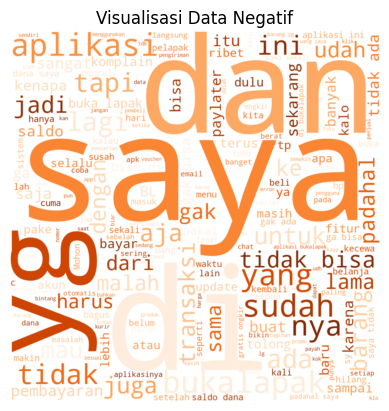

In [30]:
all_text_s0 = ' '.join(word for word in data_negatif['content'])
wordcloud = WordCloud(colormap='Oranges_r', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_s0)
plt.figure(figure=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Visualisasi Data Negatif')
plt.margins(x=0,y=0)
plt.show()

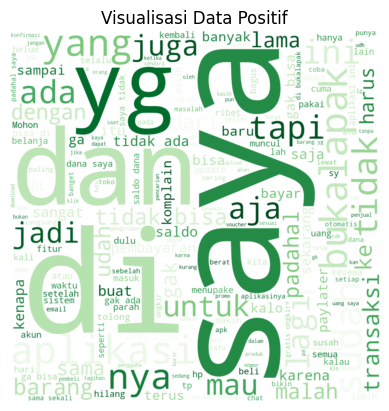

In [34]:
all_text_s1 = ' '.join(word for word in data_positif['content'])
wordcloud = WordCloud(colormap='Greens', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_s0)
plt.figure(figure=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Visualisasi Data Positif')
plt.margins(x=0,y=0)
plt.show()

In [35]:
# periksa jumlah Sentimen/label negatif dan positif
jumlah_label = data['Sentimen'].value_counts()
print(jumlah_label)

Sentimen
Negatif    667
Positif    432
Name: count, dtype: int64


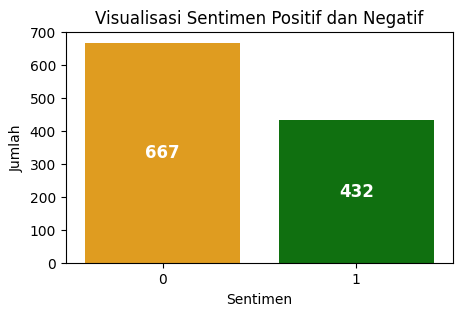

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Memastikan kolom 'Sentimen' memiliki tipe data string
data_clean['Sentimen'] = data_clean['Sentimen'].astype(str)

# Membuat plot ukuran 5x3
plt.figure(figsize=(5, 3))

# Menggunakan parameter hue untuk palet warna
ax = sns.countplot(data=data_clean, x='Sentimen', hue='Sentimen', palette={'0': 'orange', '1': 'green'}, dodge=False)

# Menambahkan judul dan label sumbu
plt.title('Visualisasi Sentimen Positif dan Negatif')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')

# Menonaktifkan legenda karena sudah terlihat pada sumbu x
plt.legend([], [], frameon=False)

# Menambahkan nama label pada setiap batang di tengah
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height / 2),
                ha='center', va='center', 
                color='white', fontsize=12, fontweight='bold')

# Menampilkan plot
plt.show()


# Data Preparation

In [37]:
# membersihkan teks dari HTML tags, emotikon, dan karakter non-alfabetik, serta mengubah teks menjadi huruf kecil

def praproses(text):
    # Menghapus tag HTML
    text = re.sub(r'<[^>]*>', '', text)
    
    # Menemukan emotikon
    emoticons = re.findall(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    
    # Menghapus karakter non-alfanumerik dan menambahkan emotikon di akhir
    text = re.sub(r'[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', '')
    
    return text

In [39]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [38]:
# Split data menjadi data train dan test (80/20)
X_train, X_test, y_train, y_test = train_test_split(data_clean['content'], data_clean['Sentimen'], test_size=0.2, random_state=42)

In [39]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(879,)
(879,)
(220,)
(220,)


In [40]:
# Oversampling menggunakan SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(tfidf_train, y_train)

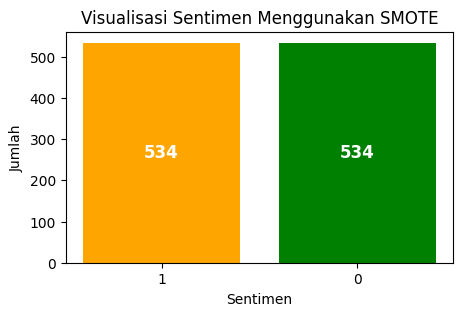

In [41]:
import matplotlib.pyplot as plt

# Mendapatkan nilai sentimen
sentimen_counts = y_train_res.value_counts()

# Membuat plot ukuran 5x3
plt.figure(figsize=(5, 3))

# Membuat bar plot
bars = plt.bar(sentimen_counts.index.astype(str), sentimen_counts.values, color=['orange', 'green'])

# Menambahkan judul dan label sumbu
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.title('Visualisasi Sentimen Menggunakan SMOTE')

# Menambahkan nama label pada setiap batang di tengah
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{int(height)}', 
                 xy=(bar.get_x() + bar.get_width() / 2, height / 2),
                 ha='center', va='center', 
                 color='white', fontsize=12, fontweight='bold')

# Menampilkan plot
plt.show()


# Modeling

In [42]:
nb = MultinomialNB()
nb.fit(X_train_res, y_train_res)

MultinomialNB()

In [43]:
y_pred = nb.predict(tfidf_test)

In [44]:
# Evaluasi model
print("MultinomialNB Accuracy:", accuracy_score(y_test, y_pred))
print("MultinomialNB Precision:", precision_score(y_test, y_pred, average="weighted", zero_division=0))
print("MultinomialNB Recall:", recall_score(y_test, y_pred, average="weighted", zero_division=0))
print("MultinomialNB F1 Score:", f1_score(y_test, y_pred, average="weighted", zero_division=0))

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=['Negatif', 'Positif'])

print(f'Akurasi Model Naive Bayes : {accuracy}')
print(53*'_')
print(f'\nLaporan Klasifikasi : \n{classification_rep}')

MultinomialNB Accuracy: 0.8590909090909091
MultinomialNB Precision: 0.8621109746109746
MultinomialNB Recall: 0.8590909090909091
MultinomialNB F1 Score: 0.8562051726558542
Akurasi Model Naive Bayes : 0.8590909090909091
_____________________________________________________

Laporan Klasifikasi : 
              precision    recall  f1-score   support

     Negatif       0.84      0.94      0.89       133
     Positif       0.89      0.74      0.81        87

    accuracy                           0.86       220
   macro avg       0.87      0.84      0.85       220
weighted avg       0.86      0.86      0.86       220



# Testing

In [49]:
# Fungsi untuk menganalisis ulasan
def analisis_ulasan():
    new_text = input("\nBeri Ulasan! : ")
    new_text_vec = tfidf_vectorizer.transform([new_text])
    predicted_sentimen = nb.predict(new_text_vec)

    predicted_sentimen_int = int(predicted_sentimen[0])

    sentimen = 'Tidak Diketahui'  # Inisialisasi variabel sentimen
    if predicted_sentimen_int == 1:
        sentimen = 'Positif'
    elif predicted_sentimen_int == 0:
        sentimen = 'Negatif'

    print(f"\nUlasan Anda : {new_text}")
    print(f"Hasil Analisis untuk Review Anda : {sentimen}")

# Meminta ulasan pengguna dan menganalisisnya
analisis_ulasan()

# Meminta ulasan kedua pengguna dan menganalisisnya
analisis_ulasan()



Ulasan Anda : Berat banget aplikasi ini di hp saya, padahal ram 8gb, unninstall aj alh.
Hasil Analisis untuk Review Anda : Negatif

Ulasan Anda :  Aplikasinya mudah digunakan dan banyak promo menarik, mantap.
Hasil Analisis untuk Review Anda : Positif
